# Context Encoder

Brief introduction to Context Encoder. This notebook is organized as follows:

1. **Research Paper**
* **Training Context Encoder with Cifar-10 dataset, Keras and TensorFlow**

## 1. Research Paper

* [Context Encoders: Feature Learning by Inpainting](https://arxiv.org/pdf/1604.07379.pdf)

## 2. Training Context Encoder with Cifar-10 dataset, Keras and TensorFlow

### 1. Load data

#### Load libraries

In [1]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from keras.datasets import cifar10
from keras.models import Sequential, Model
from keras.layers import Input, Dense, LeakyReLU, BatchNormalization, ReLU
from keras.layers import Conv2D, Conv2DTranspose, Reshape, Flatten, Dropout, UpSampling2D
from keras.optimizers import Adam
from keras import initializers
from keras.utils import plot_model, np_utils
from keras import backend as K

Using TensorFlow backend.


#### Getting the data

In [3]:
# load dataset
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

#### Explore visual data

The CIFAR-10 images are RGB with 10 classes

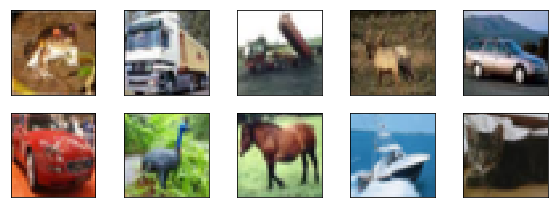

In [4]:
fig = plt.figure(figsize=(8,3))
for i in range(0, 10):
    plt.subplot(2, 5, 1 + i, xticks=[], yticks=[])
    plt.imshow(X_train[i])
    
plt.tight_layout()

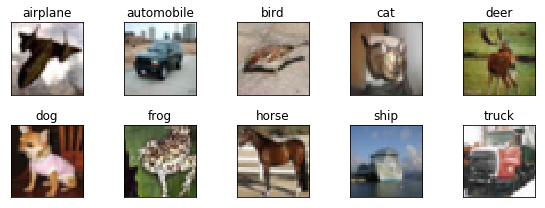

In [5]:
num_classes = len(np.unique(y_train))
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = plt.subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(y_train[:]==i)[0]
    features_idx = X_train[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    img = features_idx[img_num,::]
    ax.set_title(class_names[i])
    plt.imshow(img)
    
plt.tight_layout()

#### Reshaping and normalizing the inputs

In [6]:
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [7]:
# Extract dogs and cats
X_cats = X_train[(y_train == 3).flatten()]
X_dogs = X_train[(y_train == 5).flatten()]
X_train = np.vstack((X_cats, X_dogs))

In [8]:
if K.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 3, 32, 32)
    X_test = X_test.reshape(X_test.shape[0], 3, 32, 32)
    input_shape = (3, 32, 32)
else:
    X_train = X_train.reshape(X_train.shape[0], 32, 32, 3)
    X_test = X_test.reshape(X_test.shape[0], 32, 32, 3)
    input_shape = (32, 32, 3)
    
# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, num_classes)
Y_test = np_utils.to_categorical(y_test, num_classes)

# the generator is using tanh activation, for which we need to preprocess 
# the image data into the range between -1 and 1.

X_train = np.float32(X_train)
X_train = (X_train / 255 - 0.5) * 2
X_train = np.clip(X_train, -1, 1)

X_test = np.float32(X_test)
X_test = (X_train / 255 - 0.5) * 2
X_test = np.clip(X_test, -1, 1)

print('X_train reshape:', X_train.shape)
print('X_test reshape:', X_test.shape)

X_train reshape: (10000, 32, 32, 3)
X_test reshape: (10000, 32, 32, 3)


### 2. Define model

#### Generator (Encoder - Decoder)

In [9]:
# latent space dimension
latent_dim = 100

# imagem shape 32x32x3
img_shape = X_train[0].shape

# Generator network
generator = Sequential()

# Encoder
generator.add(Conv2D(32, kernel_size=3, strides=2, padding='same', input_shape=(img_shape)))
generator.add(BatchNormalization(momentum=0.8))
generator.add(LeakyReLU(0.2))
generator.add(Conv2D(64, kernel_size=3, strides=2, padding='same'))
generator.add(BatchNormalization(momentum=0.8))
generator.add(LeakyReLU(0.2))
generator.add(Conv2D(128, kernel_size=3, strides=2, padding='same'))
generator.add(BatchNormalization(momentum=0.8))
generator.add(LeakyReLU(0.2))
generator.add(Conv2D(512, kernel_size=1, strides=2, padding='same'))
generator.add(LeakyReLU(0.2))
generator.add(Dropout(0.5))

# Decoder
generator.add(UpSampling2D())
generator.add(Conv2D(128, kernel_size=3, padding='same', activation='relu'))
generator.add(BatchNormalization(momentum=0.8))
generator.add(UpSampling2D())
generator.add(Conv2D(64, kernel_size=3, padding='same', activation='relu'))
generator.add(BatchNormalization(momentum=0.8))

generator.add(Conv2D(3, kernel_size=3, padding='same', activation='tanh'))

#### Generator model visualization

In [10]:
# prints a summary representation of your model
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 16, 16, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 32)        128       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 64)          18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 8, 8, 64)          256       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 128)         73856     
__________

#### Discriminator


In [11]:
mask_width = 8
mask_height = 8
channels = 3
missing_shape = (mask_height, mask_width, channels)

# Discriminator network
discriminator = Sequential()

# Conv 1: 16x16x64
discriminator.add(Conv2D(64, kernel_size=3, strides=2, padding='same', input_shape=(missing_shape)))
discriminator.add(LeakyReLU(0.2))

# Conv 2:
discriminator.add(Conv2D(128, kernel_size=3, strides=2, padding='same'))
discriminator.add(BatchNormalization())
discriminator.add(LeakyReLU(0.2))

# Conv 3: 
discriminator.add(Conv2D(256, kernel_size=3, padding='same'))
discriminator.add(BatchNormalization())
discriminator.add(LeakyReLU(0.2))

# FC
discriminator.add(Flatten())

# Output
discriminator.add(Dense(1, activation='sigmoid'))

#### Discriminator model visualization

In [12]:
# prints a summary representation of your model
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 4, 4, 64)          1792      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 4, 4, 64)          0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 2, 2, 128)         73856     
_________________________________________________________________
batch_normalization_6 (Batch (None, 2, 2, 128)         512       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 2, 2, 128)         0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 2, 2, 256)         295168    
_________________________________________________________________
batch_normalization_7 (Batch (None, 2, 2, 256)         1024      
__________

### 3. Compile model

#### Compile discriminator

In [13]:
# Optimizer
optimizer = Adam(lr=0.0002, beta_1=0.5)

discriminator.compile(optimizer=optimizer, loss='binary_crossentropy',
                      metrics=['accuracy'])

#### Combined network

In [14]:
# The generator takes noise as input and generates imgs
masked_img = Input(shape=(img_shape))
gen_img = generator(masked_img)

# For the combined model we will only train the generator
discriminator.trainable = False

validity = discriminator(gen_img)

d_g = Model(inputs=masked_img, outputs=[gen_img, validity])

d_g.compile(optimizer=optimizer, loss=['mse', 'binary_crossentropy'],
            loss_weights=[0.999, 0.001])

#### GAN model vizualization

In [15]:
# prints a summary representation of your model
d_g.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 8, 8, 3)           826435    
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 373377    
Total params: 1,199,812
Trainable params: 825,603
Non-trainable params: 374,209
_________________________________________________________________


#### Mask

In [16]:
def mask_randomly(imgs):
    y1 = np.random.randint(0, imgs.shape[1] - mask_height, imgs.shape[0])
    y2 = y1 + mask_height
    x1 = np.random.randint(0, imgs.shape[2] - mask_width, imgs.shape[0])
    x2 = x1 + mask_width

    masked_imgs = np.empty_like(imgs)
    missing_parts = np.empty((imgs.shape[0], mask_height, mask_width, channels))
    for i, img in enumerate(imgs):
        masked_img = img.copy()
        _y1, _y2, _x1, _x2 = y1[i], y2[i], x1[i], x2[i]
        missing_parts[i] = masked_img[_y1:_y2, _x1:_x2, :].copy()
        masked_img[_y1:_y2, _x1:_x2, :] = 0
        masked_imgs[i] = masked_img

    return masked_imgs, missing_parts, (y1, y2, x1, x2)

### 4. Fit model


epoch = 1/100, d_loss=0.189, g_loss=0.240                                                                                                                      


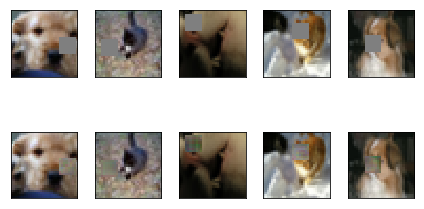

epoch = 2/100, d_loss=0.182, g_loss=0.212                                                                                                                      
epoch = 3/100, d_loss=0.167, g_loss=0.212                                                                                                                      
epoch = 4/100, d_loss=0.168, g_loss=0.204                                                                                                                      
epoch = 5/100, d_loss=0.166, g_loss=0.190                                                                                                                      
epoch = 6/100, d_loss=0.164, g_loss=0.172                                                                                                                      
epoch = 7/100, d_loss=0.164, g_loss=0.196                                                                                                                      
epoch = 8/100, d_loss=0.168, g_loss=0.17

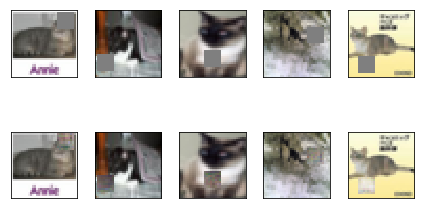

epoch = 12/100, d_loss=0.163, g_loss=0.194                                                                                                                      
epoch = 13/100, d_loss=0.164, g_loss=0.166                                                                                                                      
epoch = 14/100, d_loss=0.163, g_loss=0.184                                                                                                                      
epoch = 15/100, d_loss=0.163, g_loss=0.173                                                                                                                      
epoch = 16/100, d_loss=0.164, g_loss=0.150                                                                                                                      
epoch = 17/100, d_loss=0.163, g_loss=0.167                                                                                                                      
epoch = 18/100, d_loss=0.163, g_lo

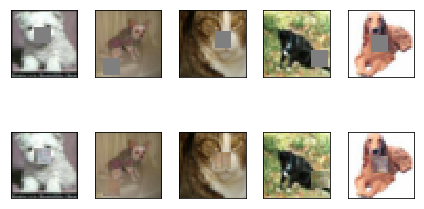

epoch = 22/100, d_loss=0.163, g_loss=0.177                                                                                                                      
epoch = 23/100, d_loss=0.163, g_loss=0.169                                                                                                                      
epoch = 24/100, d_loss=0.163, g_loss=0.144                                                                                                                      
epoch = 25/100, d_loss=0.163, g_loss=0.165                                                                                                                      
epoch = 26/100, d_loss=0.163, g_loss=0.148                                                                                                                      
epoch = 27/100, d_loss=0.163, g_loss=0.168                                                                                                                      
epoch = 28/100, d_loss=0.163, g_lo

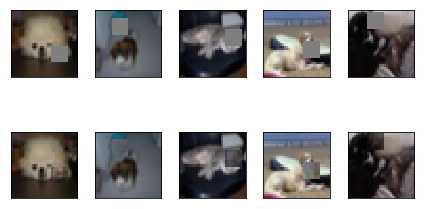

epoch = 32/100, d_loss=0.164, g_loss=0.144                                                                                                                      
epoch = 33/100, d_loss=0.163, g_loss=0.158                                                                                                                      
epoch = 34/100, d_loss=0.166, g_loss=0.149                                                                                                                      
epoch = 35/100, d_loss=0.168, g_loss=0.136                                                                                                                      
epoch = 36/100, d_loss=0.165, g_loss=0.146                                                                                                                      
epoch = 37/100, d_loss=0.164, g_loss=0.143                                                                                                                      
epoch = 38/100, d_loss=0.163, g_lo

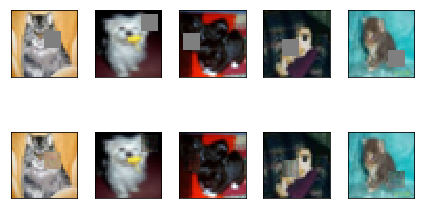

epoch = 42/100, d_loss=0.163, g_loss=0.109                                                                                                                      
epoch = 43/100, d_loss=0.168, g_loss=0.132                                                                                                                      
epoch = 44/100, d_loss=0.172, g_loss=0.126                                                                                                                      
epoch = 45/100, d_loss=0.163, g_loss=0.157                                                                                                                      
epoch = 46/100, d_loss=0.163, g_loss=0.137                                                                                                                      
epoch = 47/100, d_loss=0.163, g_loss=0.128                                                                                                                      
epoch = 48/100, d_loss=0.163, g_lo

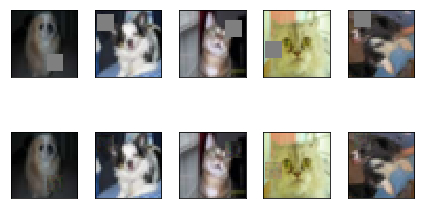

epoch = 52/100, d_loss=0.163, g_loss=0.116                                                                                                                      
epoch = 53/100, d_loss=0.163, g_loss=0.128                                                                                                                      
epoch = 54/100, d_loss=0.163, g_loss=0.160                                                                                                                      
epoch = 55/100, d_loss=0.163, g_loss=0.136                                                                                                                      
epoch = 56/100, d_loss=0.163, g_loss=0.127                                                                                                                      
epoch = 57/100, d_loss=0.164, g_loss=0.135                                                                                                                      
epoch = 58/100, d_loss=0.163, g_lo

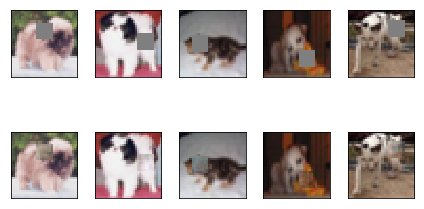

epoch = 62/100, d_loss=0.164, g_loss=0.141                                                                                                                      
epoch = 63/100, d_loss=0.163, g_loss=0.130                                                                                                                      
epoch = 64/100, d_loss=0.163, g_loss=0.132                                                                                                                      
epoch = 65/100, d_loss=0.163, g_loss=0.145                                                                                                                      
epoch = 66/100, d_loss=0.163, g_loss=0.125                                                                                                                      
epoch = 67/100, d_loss=0.163, g_loss=0.119                                                                                                                      
epoch = 68/100, d_loss=0.163, g_lo

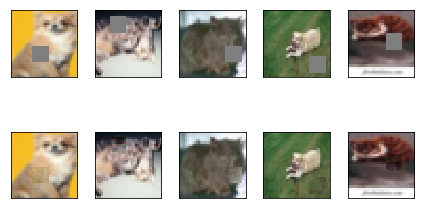

epoch = 72/100, d_loss=0.163, g_loss=0.142                                                                                                                      
epoch = 73/100, d_loss=0.163, g_loss=0.114                                                                                                                      
epoch = 74/100, d_loss=0.163, g_loss=0.140                                                                                                                      
epoch = 75/100, d_loss=0.164, g_loss=0.119                                                                                                                      
epoch = 76/100, d_loss=0.163, g_loss=0.129                                                                                                                      
epoch = 77/100, d_loss=0.163, g_loss=0.133                                                                                                                      
epoch = 78/100, d_loss=0.163, g_lo

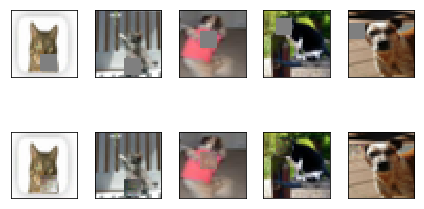

epoch = 82/100, d_loss=0.163, g_loss=0.141                                                                                                                      
epoch = 83/100, d_loss=0.166, g_loss=0.149                                                                                                                      
epoch = 84/100, d_loss=0.163, g_loss=0.133                                                                                                                      
epoch = 85/100, d_loss=0.163, g_loss=0.099                                                                                                                      
epoch = 86/100, d_loss=0.163, g_loss=0.136                                                                                                                      
epoch = 87/100, d_loss=0.163, g_loss=0.114                                                                                                                      
epoch = 88/100, d_loss=0.163, g_lo

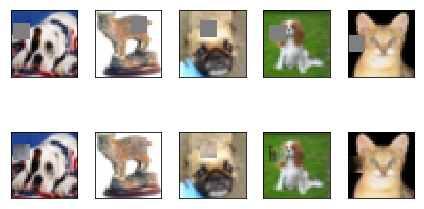

epoch = 92/100, d_loss=0.163, g_loss=0.118                                                                                                                      
epoch = 93/100, d_loss=0.163, g_loss=0.122                                                                                                                      
epoch = 94/100, d_loss=0.168, g_loss=0.137                                                                                                                      
epoch = 95/100, d_loss=0.165, g_loss=0.121                                                                                                                      
epoch = 96/100, d_loss=0.167, g_loss=0.103                                                                                                                      
epoch = 97/100, d_loss=0.164, g_loss=0.133                                                                                                                      
epoch = 98/100, d_loss=0.163, g_lo

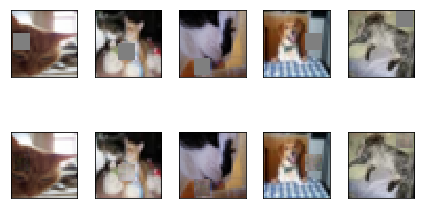

In [18]:
epochs = 100
batch_size = 64
smooth = 0.1

real = np.ones(shape=(batch_size, 1))
fake = np.zeros(shape=(batch_size, 1))

d_loss = []
d_g_loss = []

for e in range(epochs + 1):
    for i in range(len(X_train) // batch_size):
        
        # Train Discriminator weights
        discriminator.trainable = True
        
        # Real samples
        X_batch = X_train[i*batch_size:(i+1)*batch_size]
        
        # Fake Samples
        masked_imgs, missing_parts, _ = mask_randomly(X_batch)
        
        d_loss_real = discriminator.train_on_batch(x=missing_parts, y=real * (1 - smooth))

        gen_missing = generator.predict_on_batch(masked_imgs)
        d_loss_fake = discriminator.train_on_batch(x=gen_missing, y=fake)
         
        # Discriminator loss
        d_loss_batch = 0.5 * (d_loss_real[0] + d_loss_fake[0])
        
        # Train Generator weights
        discriminator.trainable = False
        g_loss_batch = d_g.train_on_batch(x=masked_imgs, y=[missing_parts, real])

        print(
            'epoch = %d/%d, batch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, i, len(X_train) // batch_size, d_loss_batch, g_loss_batch[0]),
            100*' ',
            end='\r'
        )
    
    d_loss.append(d_loss_batch)
    d_g_loss.append(g_loss_batch[0])
    print('epoch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, d_loss[-1], d_g_loss[-1]), 100*' ')
    
    if e % 10 == 0:
        samples = 5
        
        idx = np.random.randint(0, X_train.shape[0], samples)
        imgs = X_train[idx]
        
        masked_imgs, missing_parts, (y1, y2, x1, x2) = mask_randomly(imgs)
        gen_missing = generator.predict_on_batch(masked_imgs)

        for k in range(samples):
            # plot masked
            plt.subplot(2, 5, k+1)
            plt.imshow(((masked_imgs[k] + 1)* 127).astype(np.uint8))
            plt.xticks([])
            plt.yticks([])
            
            filled_in = imgs[k].copy()
            filled_in[y1[k]:y2[k], x1[k]:x2[k], :] = gen_missing[k]

            # plot recontructed
            plt.subplot(2, 5, k+6)
            plt.imshow(((filled_in + 1) * 127).astype(np.uint8))
            plt.xticks([])
            plt.yticks([])


        plt.tight_layout()
        plt.show()

### 5. Evaluate model

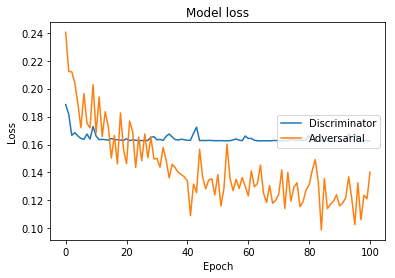

In [20]:
# plotting the metrics
plt.plot(d_loss)
plt.plot(d_g_loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Discriminator', 'Adversarial'], loc='center right')
plt.show()